In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 723.1/723.1 kB 4.0 MB/s eta 0:00:0000:0100:01


In [2]:
import ultralytics
from ultralytics import YOLO
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
wandb.init(mode="disabled")
import shutil

In [3]:
if os.path.exists('dataset'):
    shutil.rmtree('dataset')
shutil.copytree('/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/', 'dataset')

'dataset'

In [4]:
files = os.listdir('dataset/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)

00306_109


(256, 192, 3)


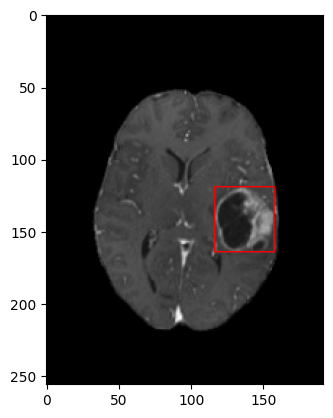

In [5]:
with open(os.path.join('dataset/labels/train', f'{random_file}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()

img = cv2.imread(os.path.join('dataset/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

In [6]:
train_images = os.listdir('dataset/images/train')
test_images = os.listdir('dataset/images/test')
train_labels = os.listdir('dataset/labels/train')
test_labels = os.listdir('dataset/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

310 75
296 75


In [7]:
os.path.splitext(random_file)[0]
unlabelled = set(train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in train_labels])

for image in unlabelled:
    os.remove(os.path.join('dataset/images/train', image))

In [8]:
train_images = os.listdir('dataset/images/train')
test_images = os.listdir('dataset/images/test')
train_labels = os.listdir('dataset/labels/train')
test_labels = os.listdir('dataset/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

296 75
296 75


In [9]:
val_split = int(num_train_images * 0.2)
val_images = random.sample(train_images, val_split)

if os.path.exists('dataset/images/val'):
    shutil.rmtree('dataset/images/val')
if os.path.exists('dataset/labels/val'):
    shutil.rmtree('dataset/labels/val')

os.mkdir('./dataset/images/val')
os.mkdir('./dataset/labels/val')

for image in val_images:
    shutil.move(os.path.join('dataset/images/train', image), 'dataset/images/val')

for image in val_images:
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('dataset/labels/train', label), 'dataset/labels/val')

In [10]:
text = """
path: /kaggle/working/dataset
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./fixed_path.yaml", 'w') as file:
    file.write(text)

In [11]:
model = YOLO('yolov9c.pt')

100%|██████████| 49.4M/49.4M [00:00<00:00, 230MB/s]


In [12]:
results = model.train(data='/kaggle/working/fixed_path.yaml', epochs=200, device=0)

Ultralytics YOLOv8.1.35 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/kaggle/working/fixed_path.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

100%|██████████| 755k/755k [00:00<00:00, 13.8MB/s]
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 72.3MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/labels/train... 237 images, 0 backgrounds, 0 corrupt: 100%|██████████| 237/237 [00:00<00:00, 1375.37it/s]

train: New cache created: /kaggle/working/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/dataset/labels/val... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<00:00, 1405.36it/s]

val: New cache created: /kaggle/working/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      11.1G      1.434          5      1.471         23        640: 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]

                   all         59         61      0.547       0.25      0.082     0.0408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      11.6G      1.198      3.158      1.263         29        640: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.252      0.314      0.119     0.0707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      11.4G      1.149      2.447      1.272         26        640: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         59         61       0.26      0.216      0.168     0.0875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      11.6G      1.207      2.151      1.331         18        640: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         59         61       0.26      0.216      0.168     0.0875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      11.6G      1.327      1.912       1.39         26        640: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         59         61       0.26      0.216      0.168     0.0875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      11.6G      1.349      1.696      1.422         19        640: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         59         61       0.26      0.216      0.168     0.0875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      11.6G      1.341        1.8      1.457         30        640: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         59         61       0.26      0.216      0.168     0.0875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      11.4G       1.29      1.551       1.35         27        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61    0.00311     0.0577    0.00095   0.000133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      11.6G      1.342      1.541       1.39         12        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         59         61      0.323       0.11      0.091     0.0591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      11.6G      1.249      1.471      1.324         27        640: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         59         61      0.489      0.181      0.129     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      11.4G      1.204      1.526      1.329         27        640: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         59         61      0.301      0.527      0.308      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      11.6G      1.226      1.331      1.338         32        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         59         61      0.428      0.447      0.349      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      11.6G      1.307       1.45      1.404         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.385      0.638      0.408      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      11.6G       1.17      1.373      1.291         19        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         59         61     0.0508     0.0385     0.0162    0.00677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      11.6G      1.191       1.36      1.321         28        640: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         59         61      0.423      0.449      0.417      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      11.6G      1.159      1.287      1.327         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.308      0.177       0.13     0.0832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      11.6G      1.194      1.264      1.307         32        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.498       0.64      0.552      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      11.6G      1.179      1.285      1.321         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.368      0.641      0.449       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      11.6G      1.069      1.195      1.241         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.379      0.798      0.529      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      11.4G      1.185      1.208      1.306         32        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.521      0.588      0.468      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      11.6G      1.142      1.158      1.272         17        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.467      0.785      0.511      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      11.6G      1.119      1.155      1.254         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         59         61      0.472      0.579      0.502      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      11.6G      1.129      1.197      1.253         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.281      0.388      0.204      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      11.6G       1.09      1.161      1.235         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.357      0.511      0.407      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      11.6G      1.103      1.122      1.229         21        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.365      0.406      0.308      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      11.6G      1.089      1.196      1.253         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.524      0.689      0.554      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      11.4G      1.125      1.183      1.255         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.428      0.832       0.52       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      11.6G      1.079      1.182      1.258         18        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.472      0.569      0.499      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      11.6G      1.069      1.151      1.238         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         59         61      0.427      0.856      0.548      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      11.6G      1.022      1.041      1.198         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.524      0.707      0.547      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      11.6G      1.091      1.054      1.245         17        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         59         61      0.461      0.679       0.59      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      11.4G      1.073      1.049      1.225         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.578      0.779      0.664       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      11.6G      1.024      1.077      1.196         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.531      0.773      0.626      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      11.6G      1.025      1.073      1.214         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.477      0.651      0.583      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      11.3G      1.054      1.012      1.217         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         59         61      0.568      0.698      0.618      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      11.4G      1.046      1.024      1.199         25        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.517      0.817      0.628      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      11.6G     0.9908     0.9831      1.207         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.661      0.664      0.694      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      11.6G      1.021      1.021      1.208         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         59         61      0.508      0.563      0.488      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      11.4G      1.022      1.031      1.192         32        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         59         61      0.477      0.192      0.211      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      11.6G      1.041     0.9866      1.234         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         59         61       0.37      0.205      0.166      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      11.6G     0.9965     0.9817      1.193         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.527      0.665      0.533      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      11.6G      1.027      1.059      1.219         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.473       0.68      0.607       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      11.6G      0.955      1.012      1.175         21        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.579      0.733      0.639      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      11.3G     0.9084     0.9633      1.143         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61       0.54      0.785      0.628      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      11.6G     0.9163     0.8913      1.128         25        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.654      0.589      0.618      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      11.6G     0.9501     0.8644      1.152         17        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.644      0.672      0.679      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      11.4G      0.957     0.8943      1.152         20        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         59         61      0.643      0.559      0.631      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      11.6G     0.9316     0.9073      1.121         28        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.571       0.74      0.683      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      11.6G     0.9529     0.8834      1.172         21        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.587      0.679      0.621      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      11.6G     0.9827      0.942      1.184         20        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.621      0.554      0.623      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      11.6G      0.963     0.9597      1.175         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.494      0.462      0.409      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      11.4G     0.9495     0.9389      1.171         20        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.576      0.624      0.599      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      11.6G     0.9406     0.9297      1.167         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.562      0.703      0.675      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      11.6G     0.9831     0.9042      1.176         20        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.467      0.727      0.592       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      11.6G      1.004     0.8672      1.163         27        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.685      0.751      0.783      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      11.4G     0.9401     0.8578      1.154         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.781       0.61       0.69      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      11.6G     0.9713     0.9259      1.183         17        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61       0.65       0.66      0.726      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      11.6G     0.8861     0.8616      1.115         17        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         59         61      0.735      0.666      0.752      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      11.3G      0.954     0.8111      1.171         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.685      0.691      0.729      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      11.6G     0.9157      0.796      1.129         30        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.652      0.591        0.6      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      11.6G     0.9104     0.8004      1.138         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.759      0.621      0.752      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      11.6G     0.9302     0.8252      1.158         20        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.756      0.621      0.717      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      11.6G     0.9118     0.7647      1.116         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         59         61      0.698      0.741      0.766      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      11.6G     0.8962     0.7872      1.117         20        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.648      0.799      0.766      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      11.6G     0.9052     0.8006      1.146         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.557      0.723      0.673      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      11.6G     0.8935     0.7603      1.137         30        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.695      0.715      0.759      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      11.6G     0.8922     0.7334      1.135         25        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         59         61      0.672      0.696      0.739      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      11.6G     0.9012     0.7972      1.137         28        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         59         61      0.792      0.584      0.724      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      11.6G     0.8754     0.7411      1.107         15        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         59         61      0.683      0.492      0.523      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      11.6G     0.8685     0.7908      1.124         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.679      0.696      0.757      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      11.4G     0.8582      0.761      1.112         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.699      0.651      0.726      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      11.6G     0.8898      0.766      1.124         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.763      0.694      0.778      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      11.6G     0.9296     0.7866      1.149         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.747      0.674      0.718      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      11.6G     0.8249      0.665      1.062         27        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.782      0.708      0.775      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      11.6G     0.8922     0.7032      1.136         25        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.693       0.68      0.726      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      11.6G      0.841     0.6641      1.089         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.783      0.688      0.829      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      11.6G     0.8199     0.6535      1.091         16        640: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.661      0.871      0.815      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      11.6G     0.8517     0.7067      1.124         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         59         61      0.819       0.58      0.805      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      11.6G     0.7952     0.6332      1.067         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.747      0.746      0.775      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      11.4G     0.7756     0.6346      1.047         20        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.553      0.804      0.732      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      11.6G     0.8077     0.6468      1.054         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.604      0.842      0.769      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      11.6G      0.797     0.6652      1.041         28        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.609      0.805      0.791      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      11.4G     0.7677     0.6437      1.058         17        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.667      0.804      0.813      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      11.6G     0.8117     0.6302      1.086         20        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.604      0.672      0.704      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      11.6G     0.8262     0.6576      1.073         21        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.615      0.693      0.707      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      11.6G     0.7829     0.5698      1.055         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.662      0.573      0.635      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      11.6G     0.7356      0.617      1.023         25        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.814        0.7      0.826      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      11.6G     0.7615      0.561      1.043         18        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.818      0.697       0.82      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      11.6G     0.7474      0.588      1.052         15        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.779      0.759      0.805       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      11.6G      0.784     0.5885      1.062         25        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         59         61      0.791       0.68      0.769      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      11.6G     0.7701     0.5854      1.054         19        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.855      0.528      0.665      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      11.3G     0.7703     0.5995       1.05         25        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61        0.8      0.774      0.824      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      11.6G     0.7142      0.555      1.019         21        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.784      0.669      0.777      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      11.6G      0.779     0.5897      1.056         25        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         59         61       0.81      0.758      0.809      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      11.6G     0.7645     0.5543      1.033         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.738      0.751      0.819      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      11.6G     0.7359     0.5649      1.039         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.651      0.773      0.768      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      11.6G     0.7589      0.577      1.043         20        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61       0.72      0.752      0.813      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      11.6G     0.6971     0.5262      1.016         30        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.708      0.677      0.784      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      11.6G     0.7811     0.5936      1.064         20        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.715      0.782      0.803      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      11.4G     0.7324     0.5717      1.029         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.832      0.741      0.812      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      11.6G     0.7238     0.5276      1.038         17        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.849      0.739       0.84      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      11.6G     0.7228     0.5306      1.021         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         59         61       0.67      0.738      0.801       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      11.3G     0.6983     0.5194      1.016         21        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         59         61      0.747      0.809       0.82      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      11.6G     0.7299     0.5086      1.028         19        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         59         61       0.72      0.752      0.829      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      11.6G     0.6929     0.5366      1.016         25        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.667      0.804      0.798      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      11.6G     0.7106     0.5472      1.028         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.718      0.759      0.807      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      11.3G     0.7065     0.5228     0.9991         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.804      0.646      0.746      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      11.6G     0.7133     0.5337      1.019         27        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.749      0.877      0.867      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      11.6G     0.7056     0.5306      1.007         19        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.884      0.751      0.891      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      11.3G     0.7088     0.5638      1.022         20        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.812      0.725      0.824      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      11.3G     0.7326     0.5029      1.033         16        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.745      0.891       0.86      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      11.6G     0.7024     0.5305     0.9948         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.683      0.727      0.767      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      11.6G     0.7035     0.5336          1         33        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.864      0.718      0.793      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      11.6G     0.7362     0.4938      1.041         28        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.801      0.822      0.847      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      11.6G     0.7274     0.5017      1.027         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.782      0.774      0.857      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      11.6G     0.6545     0.4724     0.9861         16        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.798      0.793      0.875      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      11.6G     0.7019     0.5158      1.038         19        640: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         59         61      0.837      0.639      0.777      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      11.6G     0.7231     0.5009      1.026         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.703      0.785      0.801      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      11.6G      0.689     0.5034     0.9928         30        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         59         61      0.684      0.713      0.675      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      11.6G     0.6966     0.5132      1.016         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.854      0.708      0.828      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      11.6G     0.6768     0.4848     0.9898         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.699      0.823      0.845      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      11.6G     0.6566     0.4608     0.9933         19        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.804      0.785      0.852      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      11.6G     0.6415     0.4443      0.975         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         59         61      0.811      0.791      0.853      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      11.4G     0.6241      0.462     0.9723         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.817      0.761      0.858      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      11.6G     0.6314     0.4439     0.9678         25        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.787      0.781      0.837      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      11.6G     0.6681     0.4647      1.009         16        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.721      0.847      0.827      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      11.6G     0.6173     0.4903     0.9755         19        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.818      0.745      0.834      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      11.4G      0.628     0.4346     0.9935         25        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.715      0.833      0.852      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      11.6G     0.6351     0.4356     0.9771         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.735      0.815      0.845      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      11.6G     0.6778     0.4798      0.981         14        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.754      0.827      0.834      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      11.6G     0.6359      0.439     0.9614         27        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         59         61      0.851      0.769       0.84       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      11.6G     0.6136     0.4419     0.9691         20        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.847      0.835      0.843      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      11.6G      0.614     0.4231     0.9775         32        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.874       0.77      0.814      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      11.6G     0.6021     0.4175     0.9614         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.777      0.809      0.865      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      11.6G     0.6627     0.4324     0.9926         21        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.803      0.734      0.845      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      11.4G     0.6135     0.4256     0.9645         27        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         59         61      0.813      0.751      0.855      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      11.6G     0.5661     0.4308     0.9429         15        640: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.895      0.737      0.862      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      11.6G     0.6245      0.419     0.9715         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.782      0.853      0.863      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      11.6G       0.59     0.4158     0.9605         31        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.791      0.782      0.877      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      11.4G     0.6265     0.4622     0.9782         12        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.848       0.79      0.853      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      11.6G     0.6008     0.3947     0.9521         21        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61       0.83      0.808      0.857       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      11.6G     0.5802     0.4023     0.9598         16        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61       0.67      0.777      0.785      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      11.3G     0.5794     0.4534     0.9618         31        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.747      0.765      0.825      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      11.6G     0.6224     0.4209     0.9947         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.806      0.684      0.814      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      11.6G     0.5813      0.427     0.9733         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.683      0.849      0.836      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      11.6G     0.6254     0.4247      0.966         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.688      0.799      0.809      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      11.6G     0.5435     0.3856      0.937         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.771      0.795      0.841      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      11.6G     0.5751      0.407     0.9648         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.767      0.788       0.82      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      11.6G     0.5652     0.4229     0.9477         18        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.756      0.719      0.795      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      11.6G     0.5357     0.3806     0.9397         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         59         61      0.826      0.745      0.836      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      11.6G     0.5569     0.3972       0.95         21        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.787      0.818      0.846      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      11.4G     0.5553     0.4179     0.9471         18        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.852      0.743      0.822      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      11.6G     0.5508     0.3974     0.9431         28        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.817      0.818      0.838      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      11.6G     0.5741      0.405     0.9489         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.828      0.808      0.846      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      11.6G     0.5422     0.3999     0.9317         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.905      0.664      0.813      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      11.6G     0.5523        0.4     0.9456         21        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.796       0.75      0.851      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      11.6G     0.5321     0.3888     0.9262         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.765      0.716      0.829      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      11.6G     0.5286     0.3855     0.9126         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.725       0.81      0.837      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      11.6G     0.5393     0.3982     0.9295         29        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.823      0.766       0.86      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      11.6G     0.5218     0.3852     0.9244         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         59         61       0.86      0.766      0.827      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      11.6G     0.5247     0.3795     0.9332         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         59         61      0.834      0.763      0.864      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      11.6G     0.5536     0.3643     0.9347         28        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         59         61      0.755      0.791      0.871      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      11.6G     0.5592     0.3833     0.9631         21        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.775      0.814      0.879      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      11.4G     0.5504     0.3819     0.9382         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.815      0.775      0.857      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      11.6G     0.5566      0.381     0.9652         22        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.816      0.814      0.852      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      11.6G     0.5651     0.4017     0.9568         21        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61       0.83      0.775      0.855      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      11.6G     0.5173     0.3681     0.9153         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.746      0.814      0.846      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      11.4G     0.5052     0.3578     0.9394         24        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.779      0.731      0.792        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      11.6G     0.5182     0.3717     0.9271         19        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.746      0.815      0.823      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      11.6G     0.4924     0.3375     0.9235         18        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61        0.8      0.804      0.866      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      11.4G     0.5117     0.3551     0.9278         13        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.823      0.777      0.859      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      11.4G     0.4948     0.3466     0.9393         21        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         59         61       0.81      0.826      0.857      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      11.6G     0.5149     0.3752     0.9548         14        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61       0.77      0.843       0.86      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      11.6G     0.4755      0.315     0.9112         19        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.777      0.871       0.88      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      11.6G     0.4954     0.3568     0.9203         26        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         59         61       0.79      0.802      0.882      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      11.6G     0.4811     0.3354      0.908         21        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.793      0.751      0.853      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      11.6G     0.4545     0.3283     0.9144         21        640: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.711      0.835      0.835      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      11.6G     0.4815     0.3525     0.9167         19        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61       0.74      0.805      0.844      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      11.6G       0.48     0.3417     0.9213         19        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.788       0.82      0.856      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      11.6G     0.4833     0.3296     0.9273         25        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         59         61       0.76      0.845      0.876      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      11.6G     0.4767      0.341     0.9189         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.768      0.812      0.877      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      11.6G     0.4524     0.3244     0.9022         30        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.754      0.842      0.874      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      11.6G     0.4841     0.3547     0.9245         21        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.772      0.819      0.858      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      11.6G     0.4553      0.319     0.9068         17        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         61      0.763      0.805      0.852      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      11.6G     0.4876     0.3388     0.9274         25        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.809      0.785      0.847       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      11.6G     0.4502     0.3177     0.8983         23        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.768      0.855      0.844      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      11.6G     0.4301     0.3273     0.8789         20        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.836      0.819      0.861      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      11.4G     0.4595     0.3298      0.904         29        640: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.838      0.828      0.869       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      11.6G     0.4477     0.3143     0.9043         27        640: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.831      0.815      0.879      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      11.6G      0.451     0.3274     0.9045         15        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.813      0.797      0.865      0.654


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      11.6G     0.4012     0.2815     0.8636         14        640: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.817      0.798      0.876      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      11.4G     0.3901     0.2651     0.8441         14        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         59         61      0.826      0.807      0.886      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      11.6G      0.395     0.2664     0.8548         14        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         59         61      0.835      0.799      0.878      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      11.6G      0.365     0.2585     0.8438         13        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61       0.82      0.824      0.876      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      11.6G     0.3485     0.2486     0.8299         14        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         59         61      0.842      0.812      0.884      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      11.4G     0.3655     0.2496     0.8514         13        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         59         61       0.83      0.844      0.882      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      11.6G     0.3573     0.2467     0.8477         15        640: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         59         61      0.831      0.853      0.882      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      11.6G     0.3329     0.2397     0.8255         13        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         59         61      0.816      0.839      0.875      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      11.6G     0.3501     0.2484     0.8347         14        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         61      0.821      0.829       0.88      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      11.6G      0.341     0.2436      0.838         13        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         61      0.823      0.814      0.875      0.651



200 epochs completed in 0.772 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 51.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.35 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25320790 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


                   all         59         61      0.799      0.793      0.876      0.684
              negative         59         26      0.777      0.802      0.877      0.714
              positive         59         35      0.821      0.784      0.875      0.653
Speed: 2.3ms preprocess, 13.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train


In [ ]:
#print(results)

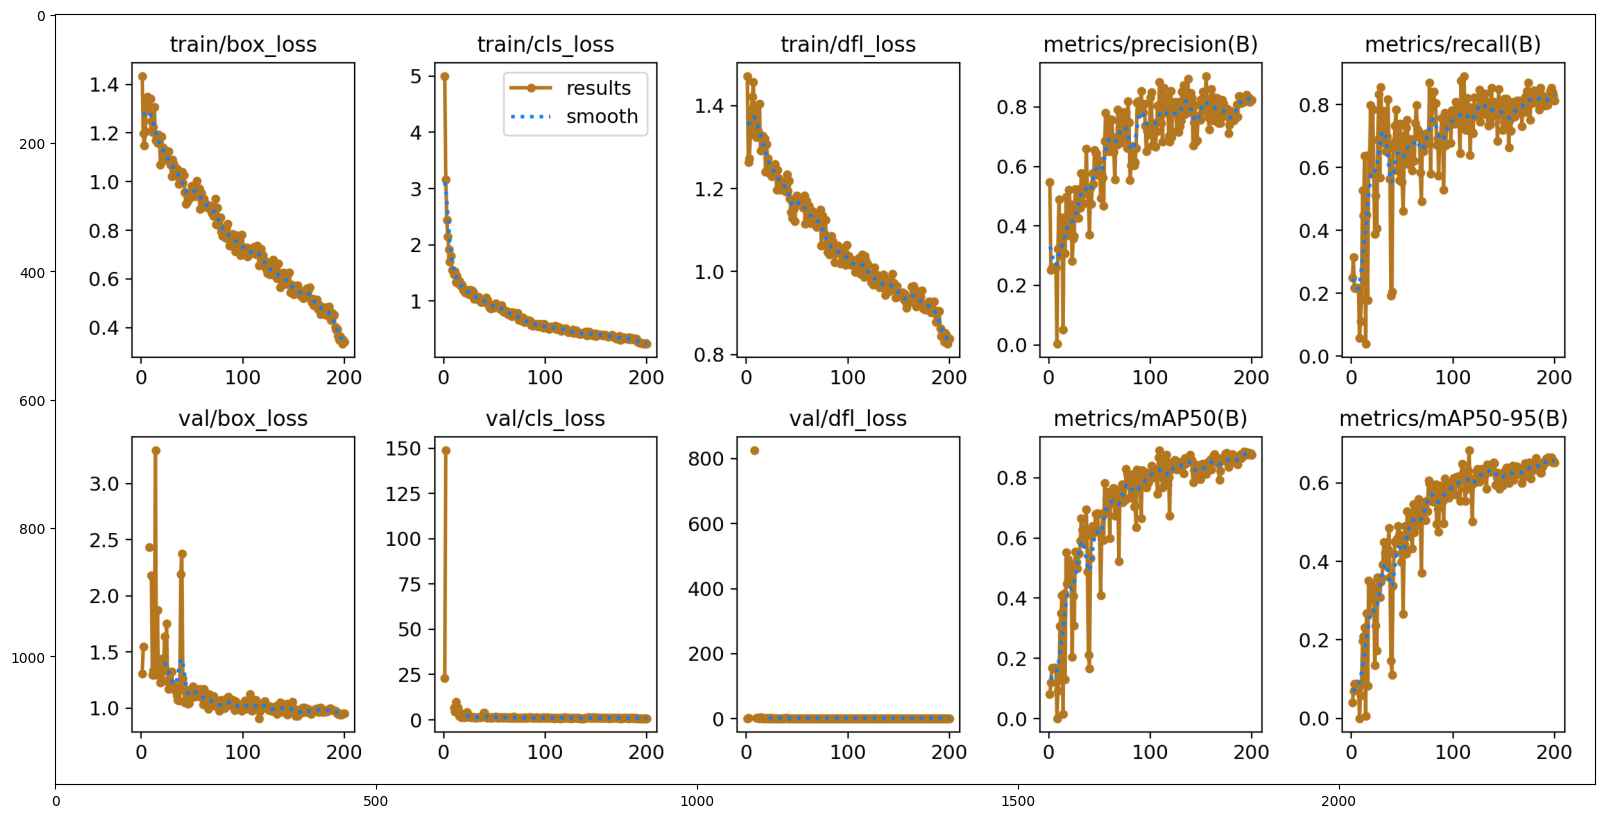

In [13]:
training_save_dir = '/kaggle/working/' + str(results.save_dir)

plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'results.png'))
plt.imshow(img)
plt.show()

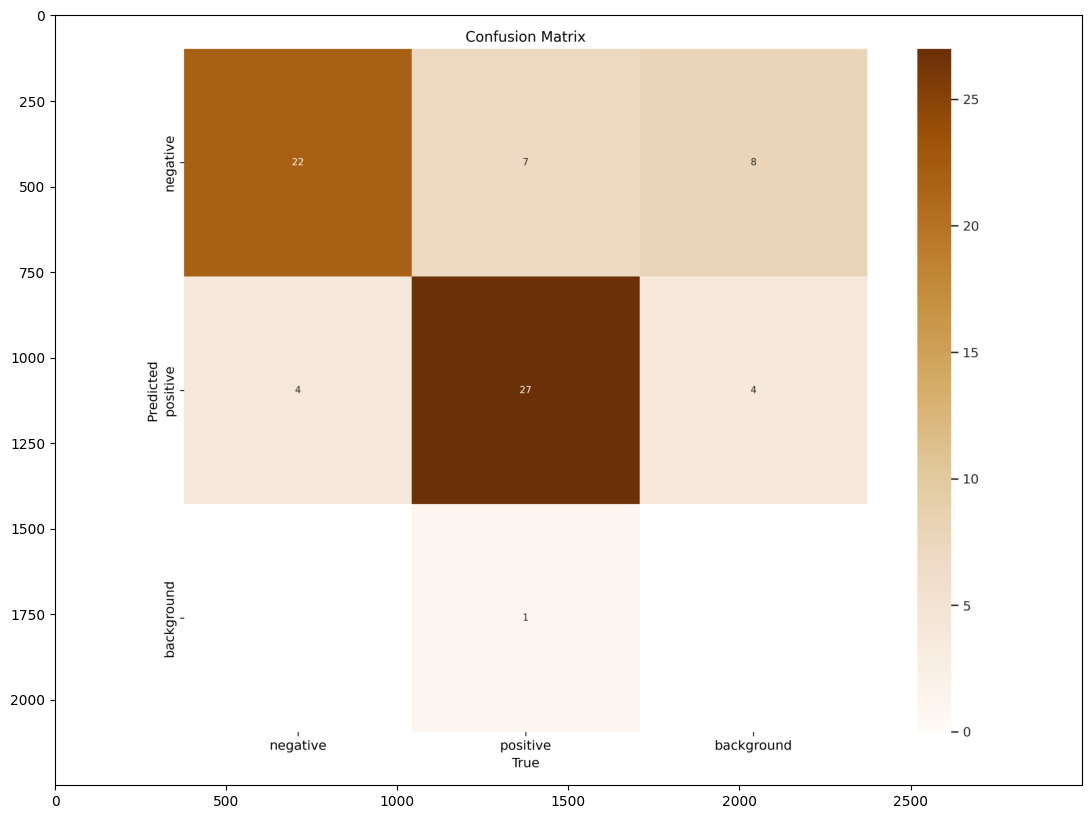

In [14]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

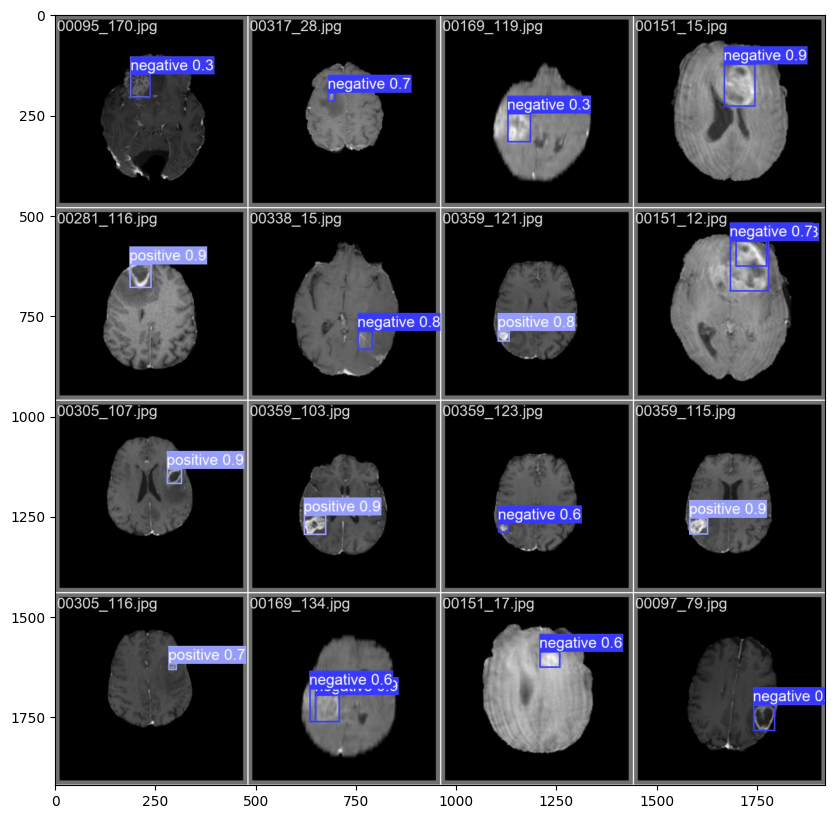

In [15]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

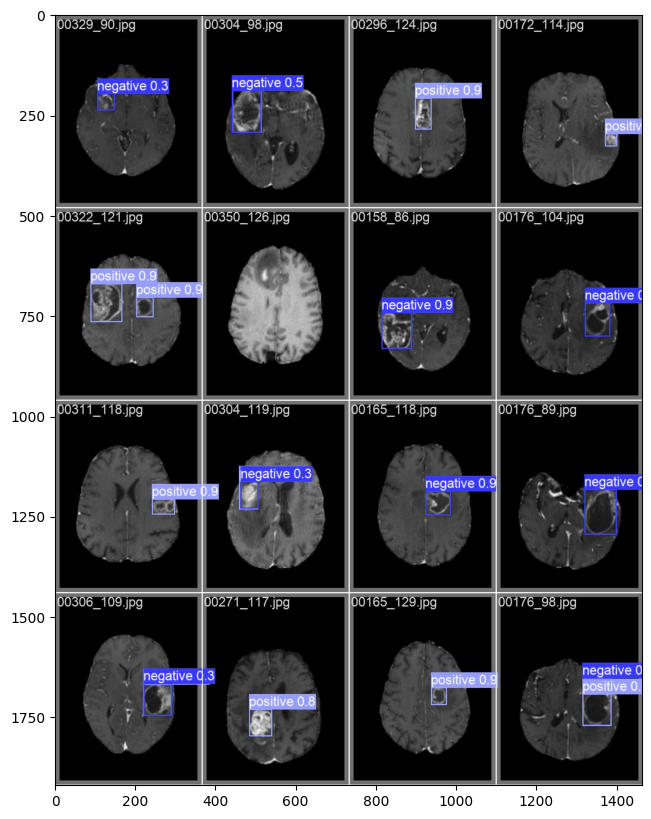

In [16]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

In [17]:
trained_model = YOLO(training_save_dir + '/weights/best.pt')
predictions = trained_model.predict(
    source="/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test",
    conf=0.4, save_txt=True, save_conf=True)


image 1/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_101.jpg: 640x640 4 negatives, 49.8ms
image 2/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_109.jpg: 640x640 1 negative, 39.7ms
image 3/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_111.jpg: 640x640 2 negatives, 39.7ms
image 4/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_117.jpg: 640x640 1 negative, 39.7ms
image 5/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_121.jpg: 640x640 1 negative, 37.7ms
image 6/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_126.jpg: 640x640 1 negative, 25.9ms
image 7/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_134.jpg: 640x640 (no detections), 27.2ms
image 8/75 /kaggle/input/brain-tu

In [18]:
#print(predictions[4])

In [19]:
predictions_save_dir = '/kaggle/working/' + predictions[0].save_dir + '/labels'

In [20]:
def draw_bbox(file_path, filename, img):
    with open(os.path.join(file_path, f'{filename}.txt'),'r') as f:
        labels = f.readlines()
        labels = labels[0].split(' ')
        print(labels)
        f.close()

    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])

    if tumor_class == 0:
        colour = (255, 0, 0)
        label = 'Negative'
    else:
        colour = (0, 255, 0)
        label = 'Positive'
    if len(labels) > 5:
        prob = float(labels[5])
        prob = round(prob, 1)
        prob = str(prob)
        label = label + ' ' + prob

    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)
    cv2.putText(img, label, (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, colour, 1)

['1', '0.593795', '0.425439', '0.08944', '0.0882145', '0.90854\n']
['0', '0.589789', '0.424296', '0.085681', '0.085681']


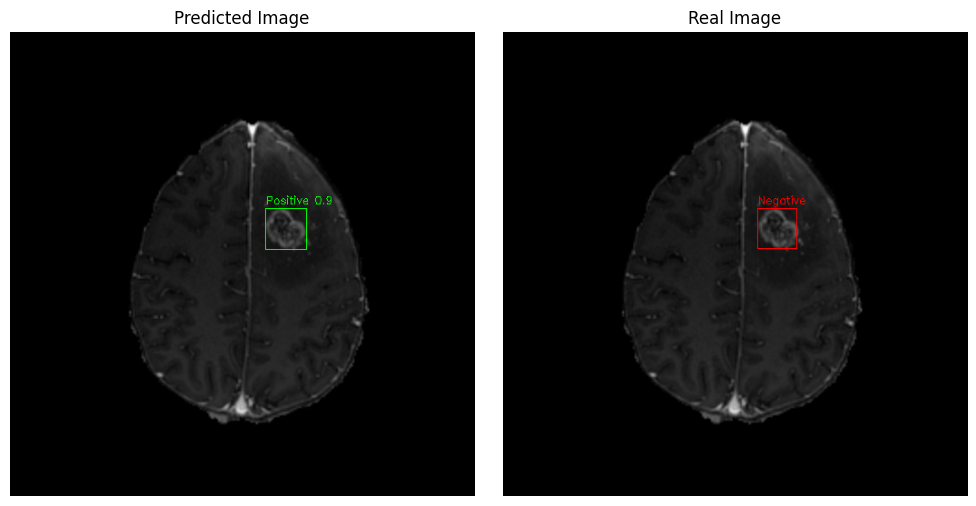

In [21]:
files = os.listdir(predictions_save_dir)
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]

img_pred = cv2.imread(os.path.join('dataset/images/test', f'{random_file}.jpg'), 1)
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
draw_bbox(predictions_save_dir, random_file, img_pred)

img_real = cv2.imread(os.path.join('dataset/images/test', f'{random_file}.jpg'), 1)
img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
draw_bbox('dataset/labels/test', random_file, img_real)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_pred)
axes[0].set_title('Predicted Image')
axes[0].axis('off')

axes[1].imshow(img_real)
axes[1].set_title('Real Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [22]:
text = """
path: /kaggle/working/dataset
train: images/train
val: images/test

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./test.yaml", 'w') as file:
    file.write(text)

In [23]:
metrics = trained_model.val(data="test.yaml")  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.1.35 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /kaggle/working/dataset/labels/test... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<00:00, 1304.14it/s]

val: New cache created: /kaggle/working/dataset/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


                   all         75         81      0.798      0.683       0.81       0.58
              negative         75         81      0.798      0.683       0.81       0.58
Speed: 4.1ms preprocess, 30.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val


In [24]:
test_save_dir = '/kaggle/working/' + str(metrics.save_dir)

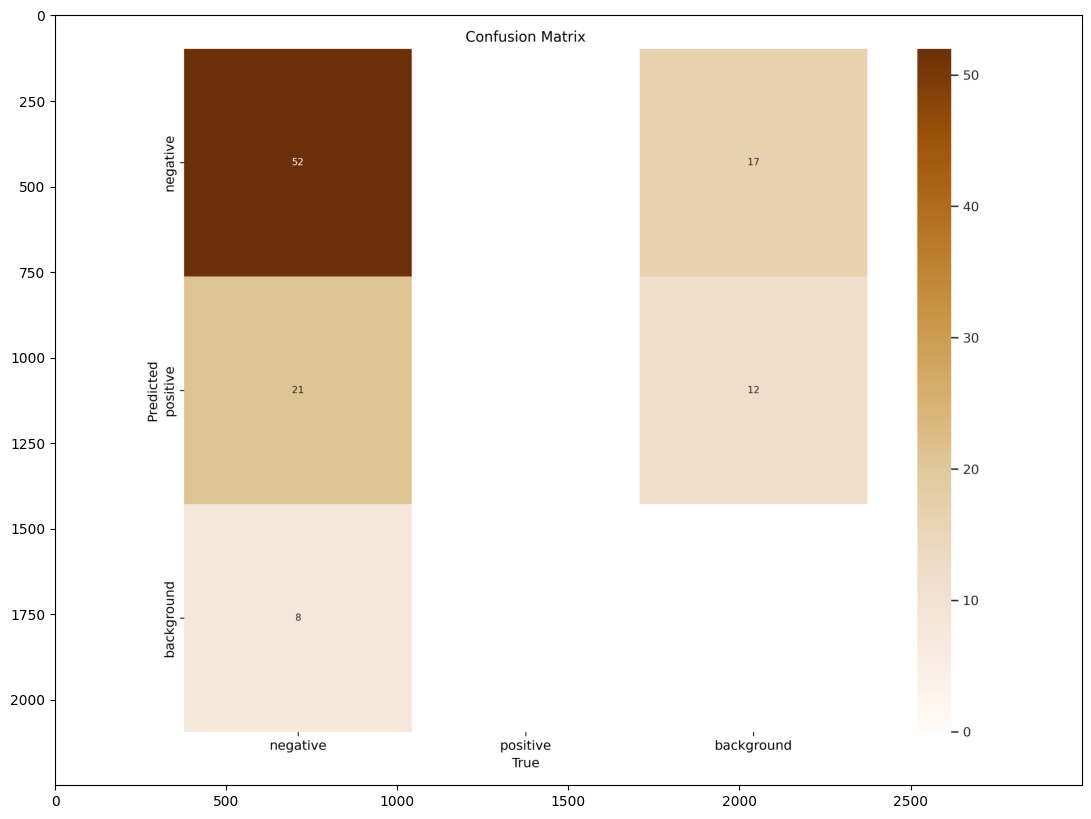

In [25]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

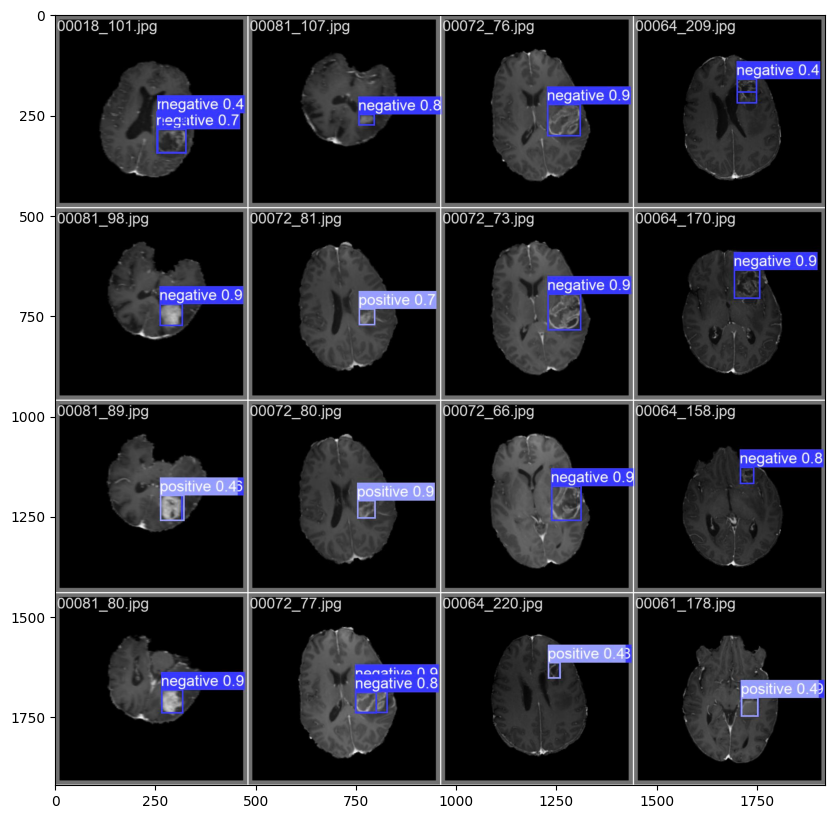

In [26]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

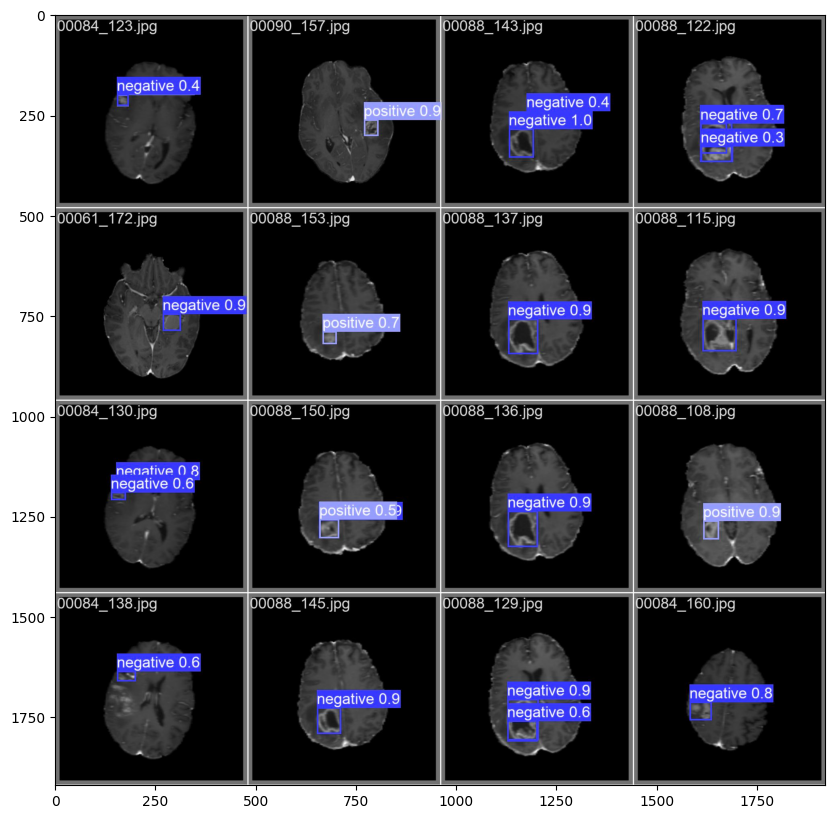

In [27]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()